In [ ]:
!pip install -q langgraph langchain_community langchain_groq wikipedia arxiv tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.2 MB/s eta 0:00:00


## LLM

### Please get GROQ_API_KEY from [console.groq.com](https://console.groq.com)

### You can use any LLM you want

In [ ]:
from langchain_groq import ChatGroq
from google.colab import userdata
GROQ_API_KEY=userdata.get('GROQ_API_KEY')
llm=ChatGroq(groq_api_key=GROQ_API_KEY,model_name="llama-3.2-90b-text-preview")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d0f4f6224a0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d0f4f623ca0>, model_name='llama-3.2-90b-text-preview', model_kwargs={}, groq_api_key=SecretStr('**********'))

##  States

In [ ]:
from typing import Annotated, TypedDict, Literal
from pydantic import Field, BaseModel
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None or str.

    Args:
        left (list | None | str): The first list to combine, or None or str.
        right (list | None | str): The second list to combine, or None str.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
               If an input is str, it's treated as a str in a list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class OverallState(TypedDict):
    Query: str
    generated_answer:str
    final_answer: str

class InputState(TypedDict):
    Query: str

class OutputState(TypedDict):
    final_answer: str

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["tavily_search", "wiki_search","arvix_search"] = Field(
        ...,
    description="Given a user question choose to route it to wikipedia or arivx (which is searh in academic paper) or tavily search(which is search in google).",)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

llm_with_router=llm.with_structured_output(RouteQuery)

# Prompt
sys_prompt = """
You are an expert at routing a user question to a arvix_search or wikipedia or tavily_search.
The arvix is a huge dataset of academic papers. So if the question needed an paper-like answer, you should use arvix.
The tavily_search is like a google search. So if the question cane be answered by a google search, you should use tavily_search.
The wiki_search is like a wikipedia search. So if the question cane be answered by a wikipedia search, you should use wiki_search.
"""
router_prompt=ChatPromptTemplate.from_messages(
   [
       ('system',sys_prompt), ('human',"{Query}"),
   ]
)

query_router= router_prompt | llm_with_router

In [180]:
print(query_router.invoke({'Query': 'what is the stock price of Tesla today?'}))

datasource='tavily_search'


## Tools

### You need to provide TAVILY_API_KEY for web search
### You can get it from [Tavily](https://tavily.com/)

In [226]:
## Working With Tools
from google.colab import userdata
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.tools import TavilySearchResults

## Arxiv
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)
## Wiki
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)
## tavily
tavily_tool = TavilySearchResults(max_results=1)

def arvix_search(state:InputState) -> OverallState:
  """ Retrieve docs from arvix. A paper dataset """
  query=state['Query']

  print('Arvix_search')
  print('---HELLO---')


  return {'generated_answer':arxiv_tool.invoke(query),'Query':query}

def wiki_search(state:InputState) -> OverallState:
  """ Retrieve docs from wikipedia """
  query=state['Query']

  print('Wiki_search')
  print('---HELLO---')

  return {'generated_answer':wiki_tool.invoke(query),'Query':query}

def tavily_search(state:InputState) -> OverallState:
  """ Retrieve docs from web search """

  print('Tavily_search')
  print('---HELLO---')

  query=state['Query']

  answer=tavily_tool.invoke(query)

  ans_str=answer[0]['content']

  return {'generated_answer': ans_str,'Query':query}

def route_question(state):
    """
    Route question to wiki_search or tavily_search or wiki_search.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["Query"]
    source = query_router.invoke({"Query": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "tavily_search":
        print("---ROUTE QUESTION TO tavily_search---")
        return "tavily_search"
    elif source.datasource == "arvix_search":
        print("---ROUTE QUESTION TO arvix_search---")
        return "arvix_search"

In [227]:
def final_answer(state:OverallState) -> OutputState:
  answer=state['generated_answer']

  prompt=""" This is a generated answer. I want you to make the text very formal without preamble: {generated_answer}"""
  final_prompt_template=ChatPromptTemplate.from_template(template=prompt)
  final_prompt= final_prompt_template.format(generated_answer=answer)

  final_answer= llm.invoke(final_prompt)

  return {'final_answer': final_answer}



## Building the Agent

In [228]:
from langgraph.graph import StateGraph,START,END

builder=StateGraph(OverallState,input=InputState,output=OutputState)

builder.add_node('wiki_search',wiki_search)
builder.add_node('tavily_search',tavily_search)
builder.add_node('arvix_search',arvix_search)
builder.add_node('Final_answer',final_answer)


builder.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "tavily_search": "tavily_search",
        "arvix_search" : "arvix_search",
    },
)

builder.add_edge('wiki_search','Final_answer')
builder.add_edge('tavily_search','Final_answer')
builder.add_edge('arvix_search','Final_answer')

builder.add_edge('Final_answer',END)

app = builder.compile()

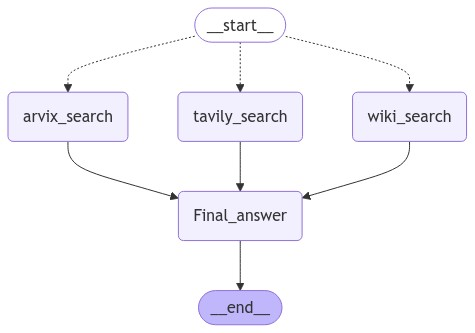

In [229]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Test the Agent

In [244]:

question={"""Query""": """REACT : SYNERGIZING REASONING AND ACTING IN LANGUAGE MODELS"""}
for output in app.stream(question):
  for k,v in output.items():
    ansss=v
ansss['final_answer'].pretty_print()

---ROUTE QUESTION---
---ROUTE QUESTION TO arvix_search---
Arvix_search
---HELLO---
================================== Ai Message ==================================

PUBLICATION DETAILS

Publication Date: 10th March 2023

TITLE AND AUTHORS

ReAct: Synergizing Reasoning and Acting in Language Models
By Shunyu Yao, Jeffrey Zhao, Dian Yu, Nan Du, Izhak Shafran, Karthik Narasimhan, and Yuan Cao

ABSTRACT

A notable paradigm shift is observed in the realm of large language models (LLMs), as their capabilities in language understanding and interactive decision-making are continually expanding. However, the integration of reasoning and acting in LLMs has predominantly been explored as disparate entities. This treatise proposes the utilization of LLMs to generate reasoning traces and task-specific actions in an iterative manner, thereby fostering a synergistic relationship between these two components. The incorporation of reasoning traces enables the model to induce, track, and update action p